## Shayan Alvansazyazdi 5447411
## Sina Hatami 5447389

# Monte Carlo and Blackjack 

In [1]:
import math
import random
import numpy as np
import collections, functools, operator
from monte_carlo_utils import *

random.seed()

# fixed variables
MAX_SUM = 21

# Rewards
WIN=1
LOSE=-1
DRAW=0

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
DECK = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

## Rules of the game

The object of the card game is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. We consider the version in which each player competes independently against the dealer. 

The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down.
Then: 
1. If the player has 21  wins unless the dealer also has 21, in which case the game is a draw.
2. Player can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust).
3.  if he sticks, then it becomes the dealer’s turn.

If the player goes bust, he loses. 
If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.


In [2]:
def draw_card():
    '''
    Uniformly draw card from infinite deck.
    '''
    return int(random.choice(DECK))

def draw_hand():
    '''
    Hand starts with 2 cards given to player
    '''
    return [draw_card(), draw_card()]

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise.

In [3]:
# A policy that sticks if the player score is >= 20 and hits otherwise.
# hits=1 and sticks=0
def player_policy(observation):
    score, dealer_showing, usable_ace = observation
    return 0 if score >= 20 else 1

def dealer_policy(current_sum):
    return 0 if current_sum >= 17 else 1

If the player holds an ace that he could count as 11 without going bust, then the ace is said to be  𝑢𝑠𝑎𝑏𝑙𝑒
 . Thus, the player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace. This makes for a total of 200 possible states.

In [4]:
def usable_ace(hand):  # Does this hand have a usable ace?
    return int(1 in hand and sum(hand) + 10 <= MAX_SUM)

def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > MAX_SUM

def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)

# compute reward based on sum of the deck
def cmp(a, b):
    return float(a > b) - float(a < b)

## Prediction 

We begin by considering Monte Carlo methods for learning the state-value function for a given policy. Each game of blackjack is an episode. To find the state-value function for this policy by a Monte Carlo
approach, one simulates many blackjack games using the policy and averages the returns following each state.

Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.

### Pseudocode of a episode:
1. Initilize episode (draw hand for both dealer & player)
2. current_state <- (player sum, dealer showing, player has a usable ace)
3. visited_states <- [current_state]
4. While the episode is done
    1. action <- policy(observation)
    2. new_state, reward = step(action) # reward meaningful when episode is done
    3. visited_state += new_state
5. Q <- {visited_states : reward} (if player_sum in visited_states > 11 )
6. return Q
    
    
    
    
### Pseudocode of step:

1. player_action <- action
2. if player_action is hits:
    1. draw card and add to player deck
    2. if is_bust(player deck)
        2.2.1 done <- True, reward <- -1
3. if player_action is sticks:

    1. while(dealer_policy == hits):
        1. draw card and add to dealer deck
    2. check points of dealer and player
    3. done <- True
    4. return (sum(player_deck), dealer_showing, has_usable_ace(player_deck)), reward, done


In [5]:
def episode(player_policy, dealer_policy):
    
    def step(player_action):
        
        done = False
        reward = DRAW # it's not meaningful unless the episode is done
        
        if player_action:  # hit: add a card to the player's hand and return
            player.append(draw_card())
            if (is_bust(player)):
                done = True
                reward = LOSE
        else:  # stick: play out the dealer's hand, and score
            while dealer_policy(sum_hand(dealer)):
                dealer.append(draw_card())
            reward = cmp(score(player), score(dealer))
            done = True
        
        # return new state, reward, if episode is done
        return (sum_hand(player), dealer_showing, usable_ace(player)), reward, done
        
    # draw two cards for the player
    player = draw_hand()
    
    # draw two cards for the dealer
    dealer = draw_hand()
    dealer_showing = dealer[0]
    
    # current state
    observation = (sum_hand(player), dealer_showing, usable_ace(player)) 
    
    visited_states = [observation]

    # run episode until player and dealer stick
    while True:
        
        # sample action
        action = player_policy(observation)
        
        # perform the action and update the current state
        observation, reward, done = step(action)
            
        if done:
            break
            
        # update visited states
        visited_states.append(observation)
    
    # visited states --> reward
    states = dict([vs_r for vs_r in zip(visited_states, [reward] * len(visited_states)) if vs_r[0][0] > 11])  
    
    return states   

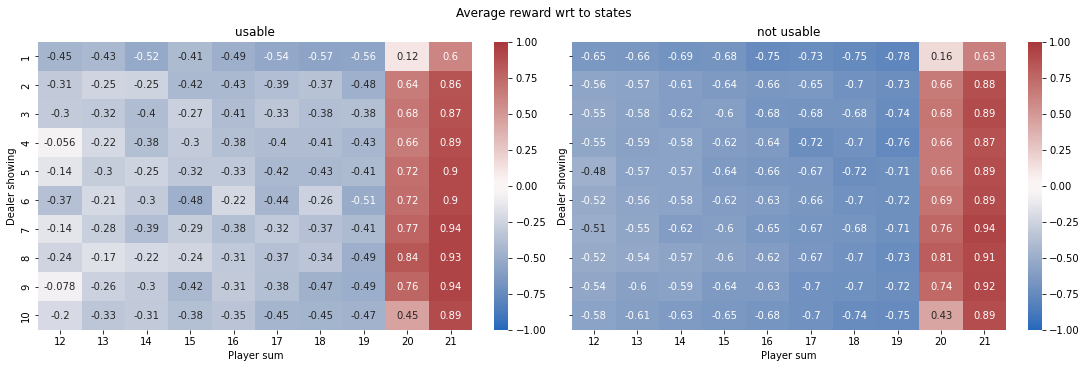

In [6]:
EPISODES = 200000 # number of episodes to play

# states --> reward
rewards = {(i, j, hold): [] for i in range(12, 22)\
              for j in range(1, 11)\
              for hold in [1, 0]} # usable, not usable

for e in range(EPISODES):
    result = episode(player_policy, dealer_policy)
        
    # append the rewards with same keys
    for state, reward in result.items():
        rewards[state].append(reward)
    
            
# compute the average reward for each state
rewards = {state: np.mean(reward) if len(reward)> 0 else None\
           for state, reward in rewards.items()}

show_rewards(rewards)

The tables show the expected rewards for each state in blackjack, estimated by averaging returns from 200,000 games played with a given policy. The tables are split based on the presence of a usable ace, and states on the left table have more uncertainty and irregularity due to their rarity. Having a usable ace increases rewards, especially with a low score.

## Control

We can consider Monte Carlo to approximate optimal policies.

In on-policy control methods the policy is generally soft, meaning that  $π(s,a)>0$
  for all  $s∈S$
  and all  $s∈A(s)$
 . There are many possible variations on on-policy methods. The on-policy method we present in this section use  $ϵ$
 -greedy policies, meaning that most of the time they choose an action that has maximum estimated action value, but with propability  ϵ
  they instead select an action at random. That is, all nongreedy actions are gievn the minimal propability of selection,  $ϵ|A(s)|$
 , and the remaining bulk of the probability, $1−ϵ+ϵ|A(s)|$
 , is given to the greedy action.
 
 One further possibility is to gradually shift the policy toward a deterministic optimal policy, hence reducing $ϵ$ with the episodes.

In [7]:
def episode_control(player_policy, dealer_policy):
    
    def step(player_action):
        
        done = False
        reward = DRAW # it's not meaningful unless the episode is done
        
        if player_action:  # hit: add a card to the player's hand and return
            player.append(draw_card())
            if (is_bust(player)):
                done = True
                reward = LOSE
        else:  # stick: play out the dealer's hand, and score
            while dealer_policy(sum_hand(dealer)):
                dealer.append(draw_card())
            reward = cmp(score(player), score(dealer))
            done = True
        
        # return new state, reward, if episode is done
        return (sum_hand(player), dealer_showing, usable_ace(player)), reward, done
        
    # draw two cards for the player
    player = draw_hand()
    
    # draw two cards for the dealer
    dealer = draw_hand()
    dealer_showing = dealer[0]
    
    # current state
    observation = (sum_hand(player), dealer_showing, usable_ace(player)) 
    
    visited_states = [observation]

    # run episode until player and dealer stick
    while True:
        
        # sample action
        action = player_policy(observation)
        
        i, j, hold = visited_states.pop()
        visited_states.append((i, j, hold, action))

        # perform the action and update the current state
        observation, reward, done = step(action)
            
        if done:
            break
            
        # update visited states
        visited_states.append(observation)
    
    # visited states --> reward
    states = dict([vs_r for vs_r in zip(visited_states, [reward] * len(visited_states)) if vs_r[0][0] > 11])  
    
    return states  

In [8]:
def update_policy(policy_dict, Q, states_episode):
    
    # update probabilities of last policy
    for state_action in states_episode:
        i, j, hold, action = state_action
        state = (i, j, hold)
        
        # update probabilities with the best reward
        props = np.ones(len(Q[state]), dtype = float) * epsilon / len(Q[state])
        try:
            means = {s: np.mean(r) for s, r in Q[state].items()}
            best_action  = max(means, key=means.get)
   
        except (ValueError, TypeError) as e:
        
            # if there is no max yet: random choice
            best_action = random.choice([0,1])
        
        
        props[best_action] += 1. - epsilon
        policy_dict[state] = props
    
    def greedy_policy(observations):
        player_sum, dealer_showing, hold = observations
        
        # we don't care if player_sum < 12: hits
        if player_sum < 12:
            return 1
        
        props= policy_dict[observations]
        action = np.random.choice(np.arange(len(props)), p = props)
        return action
    
    return greedy_policy, policy_dict
    
    
    
def run_experiment_control(player_policy, policy_dict, dealer_policy, n_episodes=100, epsilon=0.01, change_policy=1):
    
    holds = [1, 0]
    actions = [0, 1]
    
    # states --> action --> reward
    Q = {(i, j, hold): {a: None for a in actions} for i in range(12, 22)\
              for j in range(1, 11)\
              for hold in holds }

    
    # run episodes
    for e in range(n_episodes):
        result = episode_control(player_policy=player_policy, dealer_policy= dealer_policy)
        
        # append the rewards with same key
        for state_action, reward in result.items():        
            i, j, hold, action = state_action
            state = (i, j, hold)
            if Q[state][action] is not None:
                Q[state][action].append(reward) 
            else:
                Q[state][action]=[reward]
            
        # update only after some episodes
        if e % change_policy != 0:
            continue
            
        # update the current policy wrt the best reward
        player_policy, policy_dict  = update_policy(policy_dict, Q, result.keys())
                    
            
    # get the reward of the optimal policy
    optimal_policy={}
    optimal_rewards={}
    for states, actions in policy_dict.items():
        i, j, hold = states
        best_a  = np.argmax(actions)
        
        # optimal policy
        optimal_policy[states]= best_a 
        
        # optimal reward
        if Q[states][best_a] is not None:
            optimal_rewards[(i, j, hold)]= np.mean(Q[states][best_a])
        else:
            optimal_rewards[(i, j, hold)]= None
    
    # plot results
    show_strategy(optimal_policy)
    show_rewards(optimal_rewards)

As the initial policy we use the policy evaluated in the previous blackjack example, that which sticks only on 20 or 21.

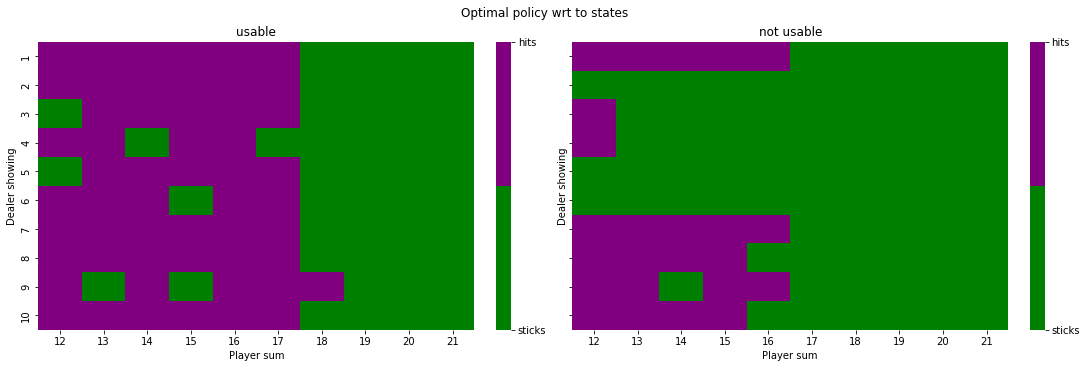

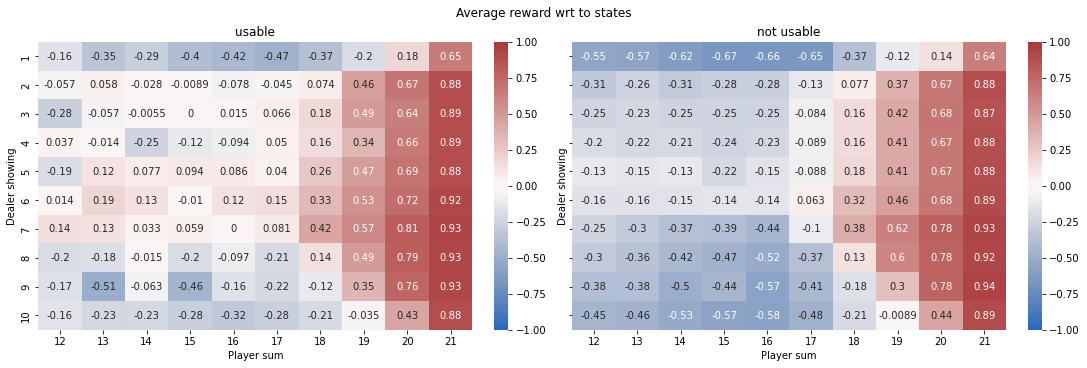

In [11]:
# hit if hand sum 
def make_epsilon_threshold_policy(actions=[0, 1] , threshold=20, epsilon=0.01):
    policy_probs = {(i, j, hold): [epsilon/len(actions) for a in actions] \
                    for i in range(12, 22)\
                      for j in range(1, 11)\
                      for hold in [1, 0]}
    
    for states, probability in policy_probs.items():
        player_sum, dealer_showing, hold = states
        if player_sum>=threshold: # sticks
            policy_probs[states][0] +=1. - epsilon
            
        if player_sum<threshold: # hits
            policy_probs[states][1] +=1. - epsilon
    
    def greedy_policy(observations):
        player_sum, dealer_showing, hold = observations
        
        # we don't care if player_sum < 12: hits
        if player_sum < 12:
            return 1
        props= policy_probs[observations]
        action = np.random.choice(np.arange(len(props)), p = props)
        return action
    
    return greedy_policy, policy_probs


EPISODES = 200000 # number of episodes to play
epsilon = 0.1

# player policy
policy_prob, policy_dict = make_epsilon_threshold_policy(threshold=20, epsilon=epsilon)

        
run_experiment_control(policy_prob, policy_dict, dealer_policy, EPISODES, epsilon)

random player policy

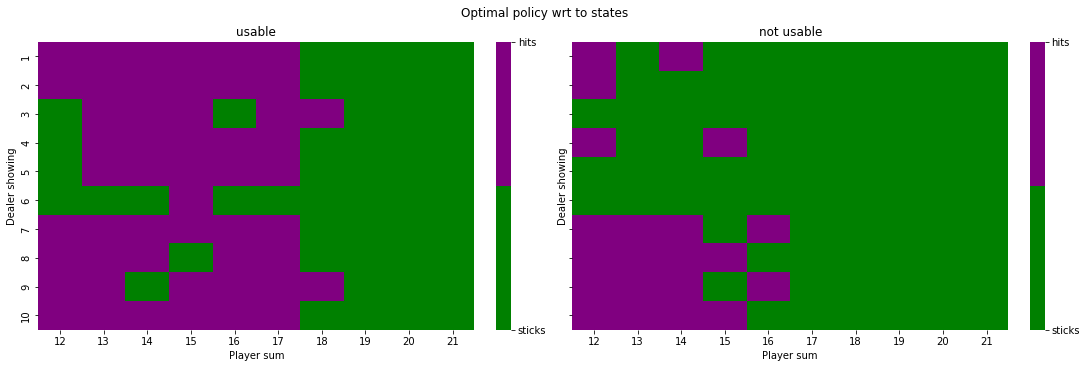

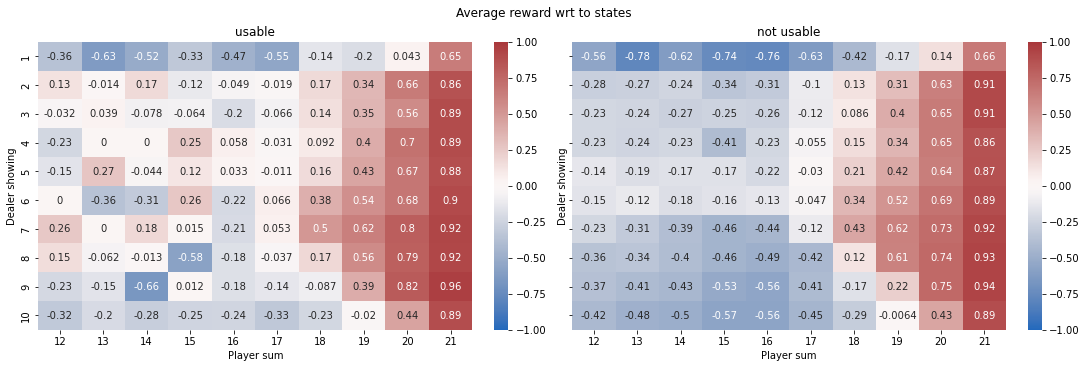

In [12]:
# hit if hand sum 
def make_random_policy(actions=[0, 1]):
    policy_probs = {(i, j, hold): [1./len(actions) for a in actions] \
                    for i in range(12, 22)\
                      for j in range(1, 11)\
                      for hold in [1, 0]}
    
    def greedy_policy(observations):
        player_sum, dealer_showing, hold = observations
        
        # we don't care if player_sum < 12: hits
        if player_sum < 12:
            return 1
        props= policy_probs[observations]
        action = np.random.choice(np.arange(len(props)), p = props)
        return action
    
    return greedy_policy, policy_probs

EPISODES = 90000 # number of episodes to play
epsilon = 0.1

# player policy
policy_prob, policy_dict = make_random_policy()

        
run_experiment_control(policy_prob, policy_dict, dealer_policy, EPISODES, epsilon)

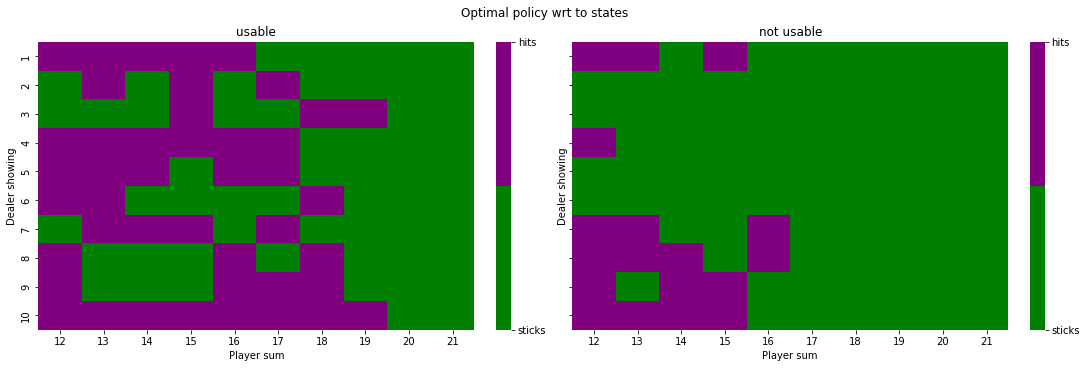

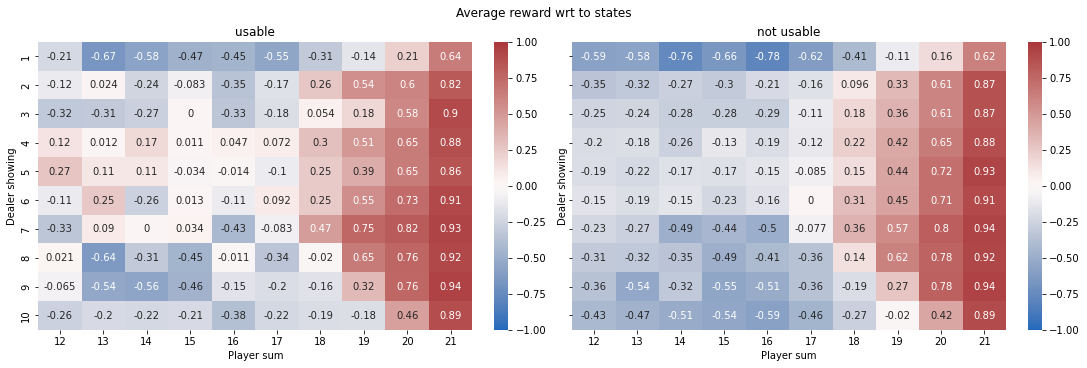

In [13]:
epsilon = 0.04 # set to a lower value

run_experiment_control(policy_prob, policy_dict, dealer_policy, EPISODES, epsilon)

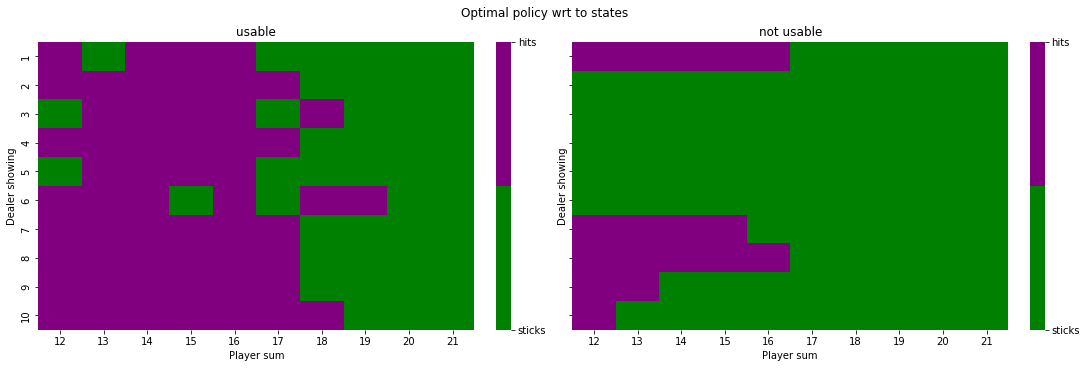

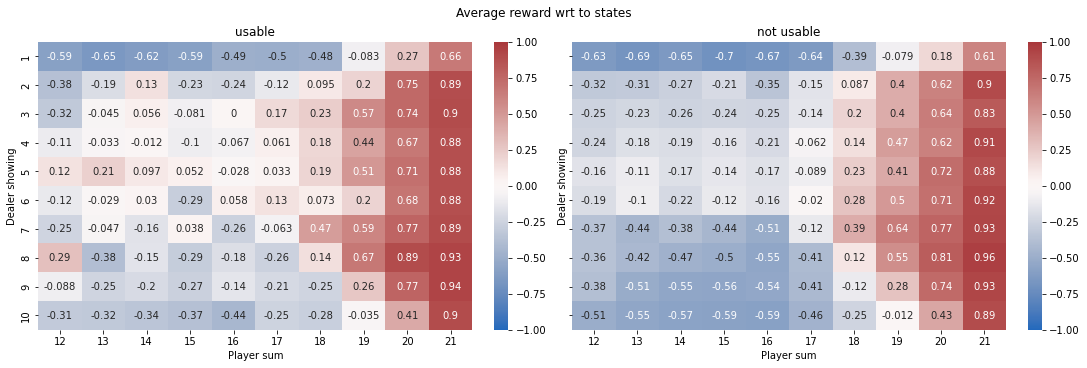

In [14]:
epsilon = 0.4 # try a high value

run_experiment_control(policy_prob, policy_dict, dealer_policy, EPISODES, epsilon)

When the value of epsilon is reduced, the average reward decreases noticeably. This is not surprising because we tend to choose the action with the highest estimated value (the greedy choice) in almost all cases.

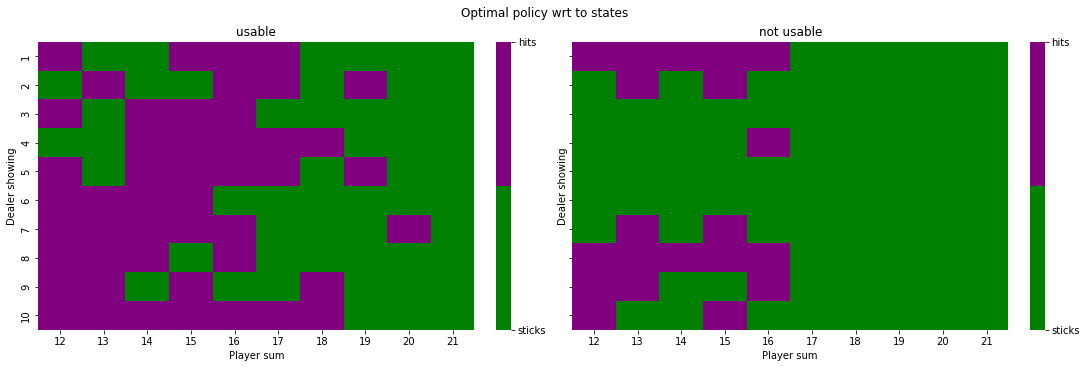

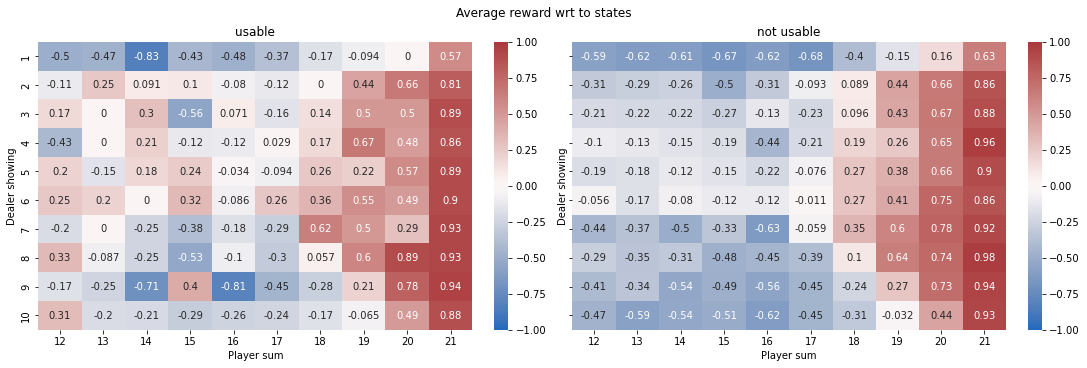

In [15]:
epsilon = 0.1
EPISODES = 30000 # set to a lower value

run_experiment_control(policy_prob, policy_dict, dealer_policy, EPISODES, epsilon)

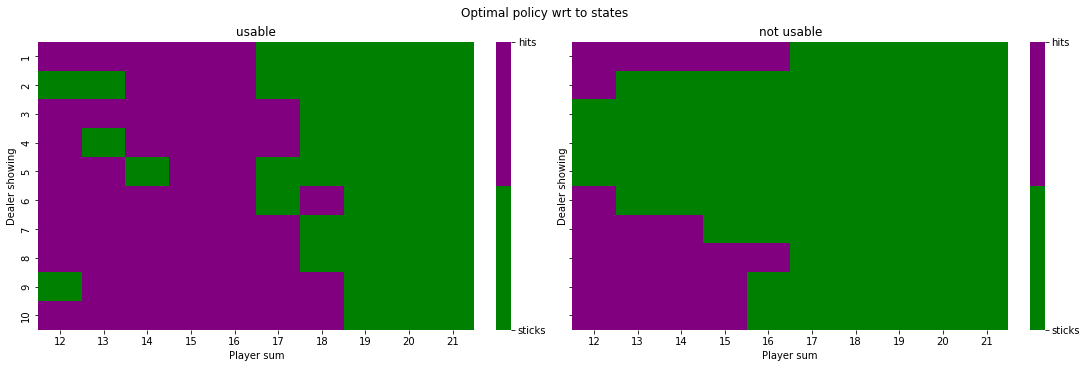

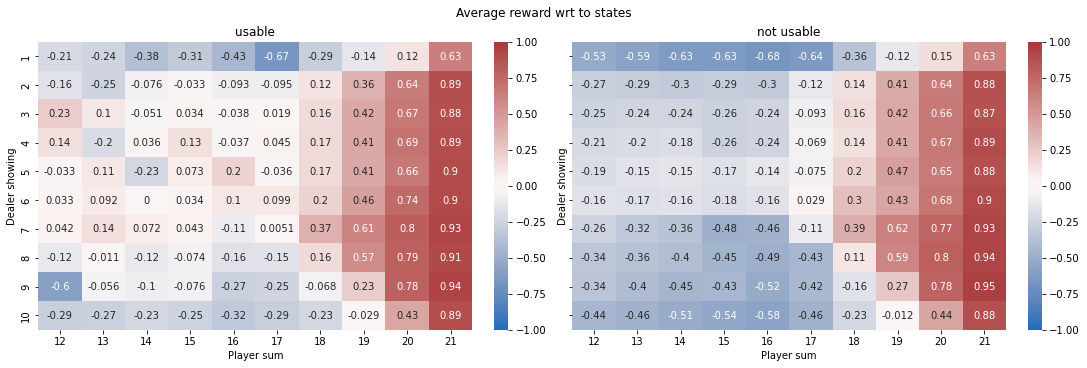

In [16]:
EPISODES = 300000 # try a higher value

run_experiment_control(policy_prob, policy_dict, dealer_policy, EPISODES, epsilon)

as we expected the more we play the better the approximation gets.